In [32]:
#get essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
#get preprocessing and metric libraries
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
#get the model and visualisation method
from nodegam.sklearn import NodeGAMRegressor
from nodegam.vis_utils import vis_GAM_effects
import seaborn as sns
%store -r time_data
%store -r temp_data
%store -r weather_data


In [105]:
%store -r month_data

In [86]:
#get the data
metro_data = pd.read_csv("../../Data/Metro/Metro_Interstate_Traffic_Volume.csv")

In [126]:
weather_dict = {'Clear': 0, 'Haze': 1, 'Mist': 2, 'Fog': 3, 'Squall':4, 'Clouds':5,
                       'Drizzle': 6, 'Rain': 7, 'Snow': 8, 'Smoke': 9, 'Thunderstorm': 10}
print(list(weather_dict.keys()))

['Clear', 'Haze', 'Mist', 'Fog', 'Squall', 'Clouds', 'Drizzle', 'Rain', 'Snow', 'Smoke', 'Thunderstorm']


In [88]:
metro_data = metro_data.replace({'weather_main': weather_dict})

In [89]:
#remove faulty measurements
metro_data = metro_data[metro_data['temp'] != 0] #temp is measured in kelvin. It is not possible that there was a day where the temperature was zero kelvin
metro_data = metro_data[metro_data['rain_1h'] != metro_data['rain_1h'].max()] #max value was 9831mm for an hour of rainfall on a m^2 space. This would be a storm of apocalypsic proportions

In [90]:
#temp is given in kelvin, convert it to celsius
metro_data['temp'] = metro_data['temp'] - 273.15

In [91]:
#If there is no holiday assign it the value 0 else give the value 1
metro_data['holiday'] = metro_data['holiday'].apply(lambda x: 0 if x == 'None' else 1)


In [92]:
#convert the date_time column to pandas date time and get date, month and hour as their own columns
metro_data['date_time'] = pd.to_datetime(metro_data['date_time'])
metro_data['day'] = metro_data['date_time'].dt.day
metro_data['month'] = metro_data['date_time'].dt.month
metro_data['time'] = metro_data['date_time'].dt.hour

In [93]:
#assign the target and training data
traffic = metro_data['traffic_volume'] / 100
x_metro = metro_data.drop(['traffic_volume', 'weather_description', 'date_time'], axis = 1)

In [94]:
#split the data to train, val and test
X_train, X_test, y_train, y_test = train_test_split(x_metro, traffic, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = (0.15 /(0.15 + 0.7)))

In [95]:
#get the column names of numerical and categorical columns. We have only one catecorigal column, "weather_main"
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == np.float64 or X_train[col].dtype == np.int64]
numerical_cols.remove('holiday')


In [96]:
#scale the numerical columns and encode the catecorigal columns
ct = ColumnTransformer([
    ("MinMax scaling numerical variables", preproc.MinMaxScaler((-1, 1)), numerical_cols)
], remainder='passthrough')
ct.fit(X_train)
X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)
columns_for_labeling = numerical_cols + ['holiday']

In [97]:
X_train = pd.DataFrame(data = X_train, columns=columns_for_labeling)
X_val = pd.DataFrame(data = X_val, columns=columns_for_labeling)
X_test = pd.DataFrame(data = X_test, columns=columns_for_labeling)


In [98]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()


In [99]:
#create and fit the model
node_reg = NodeGAMRegressor(
            ga2m=0,
            max_steps=3000,
            device='cpu',
            in_features=9
            )
node_reg.fit(X_train, y_train)

Normalize y. mean = 32.581715132651546, std = 19.849443395206915
Steps	Train Err	Val Metric (mse)
100	0.4919	267.3545
200	0.327	220.4269
300	0.5123	215.4535
400	0.4168	210.4123
500	0.353	202.7331
600	0.0691	162.5696
700	0.288	129.3216
800	0.2542	131.3782
900	0.5327	120.381
1000	0.2401	109.4955
1100	0.2579	103.4336
1200	0.0227	95.7653
1300	0.2479	94.1424
1400	0.2348	92.5545
1500	0.0105	92.1976
1600	0.2914	93.6602
1700	0.2456	96.9907
1800	0.0194	99.5233
1900	0.2211	96.8407
2000	0.2378	94.1047
2100	1.0103	92.7558
2200	0.2518	93.6536
2300	0.4015	92.4318
2400	0.1427	91.0136
2500	0.2153	91.6798
2600	0.2782	92.6151
2700	0.3963	92.0764
2800	0.2279	92.2843
2900	0.2313	93.2207
3000	0.3957	93.4523
LR: 1.00e-02 -> 2.00e-03
End. It reaches the maximum steps 3000
Total training time: 631.7 seconds
Best step:  2400
Best Val Metric:  91.01361413114394
Load the best checkpoint.


{'train_losses': [1.071645736694336,
  1.3323031663894653,
  0.9604378938674927,
  1.1152071952819824,
  1.337972640991211,
  1.078498363494873,
  1.1195173263549805,
  1.0307536125183105,
  0.9843117594718933,
  1.3908140659332275,
  1.2277929782867432,
  1.0055102109909058,
  1.0926178693771362,
  1.0210614204406738,
  1.5183980464935303,
  1.0583171844482422,
  0.9509005546569824,
  1.2057290077209473,
  1.1905431747436523,
  0.970973014831543,
  1.321561574935913,
  1.1891592741012573,
  0.9541218280792236,
  1.37147855758667,
  1.3109922409057617,
  0.9075817465782166,
  1.047211766242981,
  1.0805000066757202,
  0.9096795916557312,
  0.764271080493927,
  0.9277974367141724,
  0.8641965985298157,
  0.9260163307189941,
  1.3728762865066528,
  0.8664911985397339,
  0.8893207311630249,
  0.9072126746177673,
  1.7715550661087036,
  0.8838533163070679,
  1.0281964540481567,
  1.0010608434677124,
  0.8360291123390198,
  1.2288182973861694,
  1.0830161571502686,
  0.21155007183551788,
  

In [100]:
predictions = node_reg.predict(X_test)
rmse_score = sk_metrics.mean_squared_error(y_test, predictions, squared=False)
print("rmse score for the model is: ", rmse_score)

rmse score for the model is:  9.320253560073716


bin features temp with uniq val 5583 to only 256
bin features rain_1h with uniq val 327 to only 256


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nodegam/gams/utils.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col_name] = pd.Series(bins)[digitized].values.astype(np.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nodegam/gams/utils.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col_name] = pd.Series(bins)[digitized].values.astype(np.float32)


Finish "Run values through model" in 1.0s


100%|██████████| 9/9 [00:00<00:00, 1220.85it/s]


Finish "Extract values" in 10ms
Finish "Purify interactions to main effects" in 0ms
Finish "Center main effects" in 0ms


100%|██████████| 10/10 [00:00<00:00, 8298.98it/s]

Finish "Construct table" in 3ms


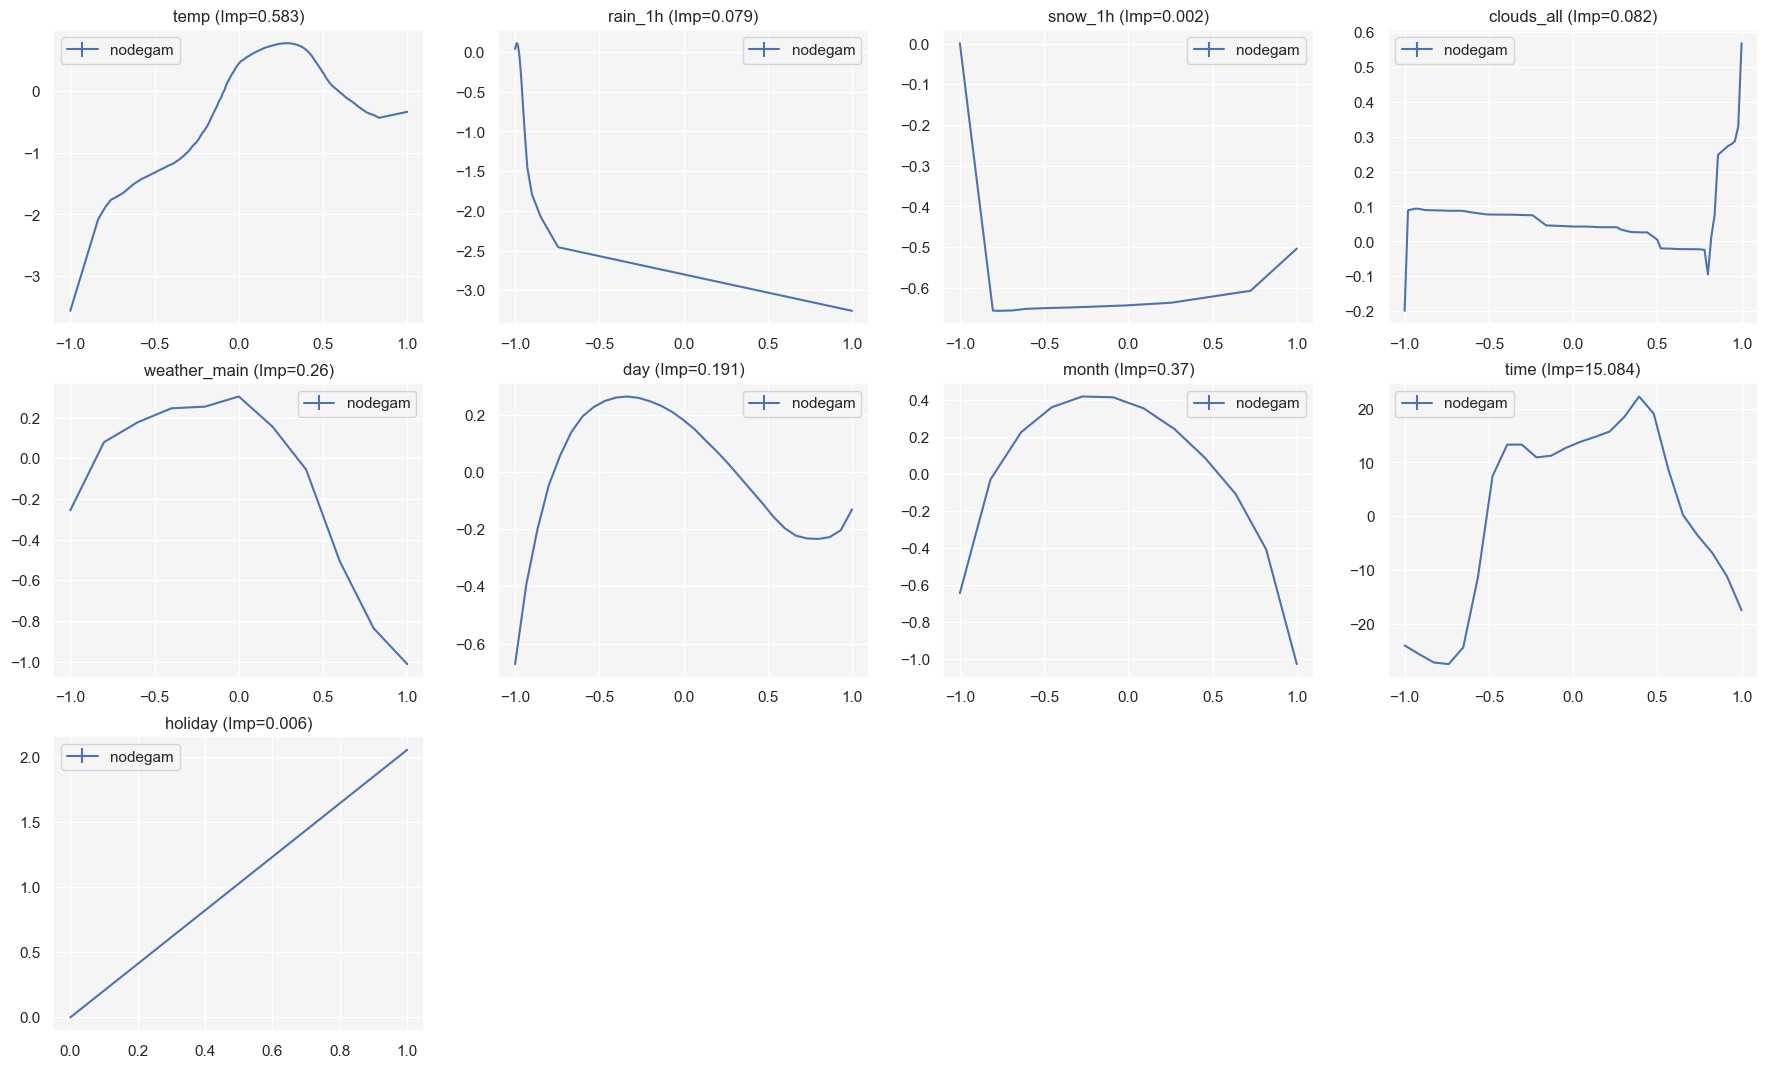

In [102]:
fig, ax = vis_GAM_effects({'nodegam': node_reg.get_GAM_df(X_train)}, top_interactions=0)


In [51]:
#set up the nam lines
nam_time_linefit = np.poly1d(np.polyfit(time_data['x'], time_data['y'], 8))
nam_temp_linefit = np.poly1d(np.polyfit(temp_data['x'], temp_data['y'], 8))
nam_weather_linefit = np.poly1d(np.polyfit(weather_data['x'], weather_data['y'], 8))

In [106]:
nam_month_linefit = np.poly1d(np.polyfit(month_data['x'], month_data['y'], 8))


(array([6105., 4112., 4146., 6175., 4030., 3860., 5891., 3918., 3940.,
        6016.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

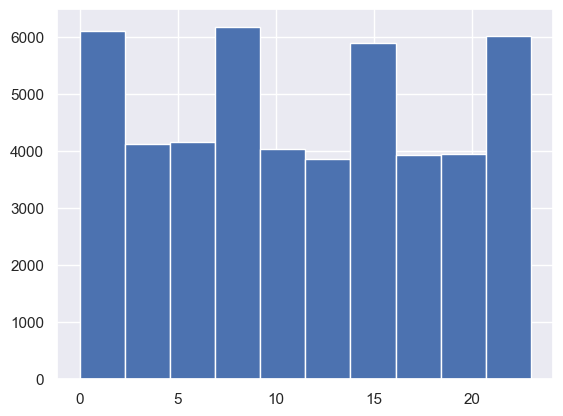

In [59]:
plt.hist(x_metro['time'])

In [142]:
visualisation_data_metro = node_reg.get_GAM_df(X_train)
%store visualisation_data_metro

bin features temp with uniq val 5583 to only 256
bin features rain_1h with uniq val 327 to only 256


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nodegam/gams/utils.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col_name] = pd.Series(bins)[digitized].values.astype(np.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nodegam/gams/utils.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col_name] = pd.Series(bins)[digitized].values.astype(np.float32)


Finish "Run values through model" in 1.3s


100%|██████████| 9/9 [00:00<00:00, 636.36it/s]


Finish "Extract values" in 19ms
Finish "Purify interactions to main effects" in 0ms
Finish "Center main effects" in 1ms


100%|██████████| 10/10 [00:00<00:00, 4672.80it/s]

Finish "Construct table" in 8ms
Stored 'visualisation_data_metro' (DataFrame)


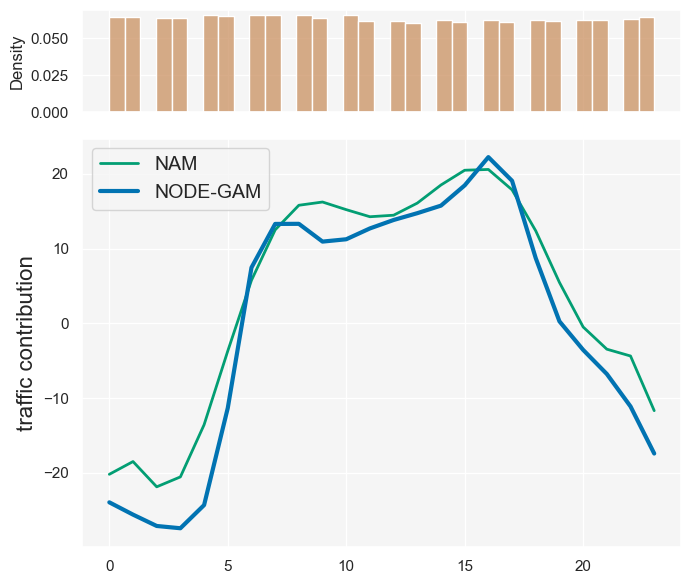

In [137]:
sns.set_theme()
sns.set_style(rc = {'axes.facecolor': 'whitesmoke'})
colorblind_colors = sns.color_palette("colorblind")
time_visualisation = visualisation_data[visualisation_data['feat_name'] == 'time']
time_values = np.linspace(x_metro['time'].min(), x_metro['time'].max(), len(time_visualisation['y'].iloc[0]))

fig, axes = plt.subplots(2, 
                         1, 
                         figsize=(7, 6),
                         sharex=True,  
                         gridspec_kw=dict(height_ratios = [1, 4])
                    )
axes[1].plot(time_values, nam_time_linefit(time_visualisation['x'].iloc[0]), color = colorblind_colors[2], linewidth = 2, label = 'NAM')
axes[1].plot(time_values, time_visualisation['y'].iloc[0], color = colorblind_colors[0], linewidth = 3, label = 'NODE-GAM')
sns.histplot(x_metro['time'], ax = axes[0], stat='density', color = colorblind_colors[5])
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
#plt.xlabel('Time (reported in hours range 0–24)', fontsize = 14)
plt.ylabel('traffic contribution', fontsize = 16)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.show()


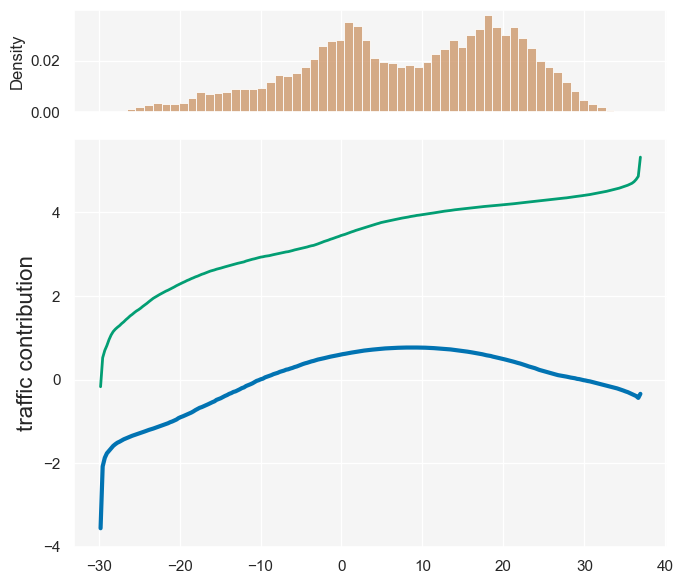

In [138]:
temp_visualisation = visualisation_data[visualisation_data['feat_name'] == 'temp'] 
temp_values = np.linspace(x_metro['temp'].min(), x_metro['temp'].max(), len(temp_visualisation['y'].iloc[0]))

fig, axes = plt.subplots(2, 
                         1, 
                         figsize=(7, 6),
                         sharex=True,  
                         gridspec_kw=dict(height_ratios = [1, 4])
                    )
axes[1].plot(temp_values, nam_temp_linefit(temp_visualisation['x'].iloc[0]), color = colorblind_colors[2], linewidth = 2, label = 'NAM')
axes[1].plot(temp_values, temp_visualisation['y'].iloc[0] , color = colorblind_colors[0], linewidth = 3, label = 'NODE-GAM')
sns.histplot(x_metro['temp'], ax = axes[0], stat='density', color = colorblind_colors[5])
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
#plt.xlabel('Temperature measured in celsius', fontsize = 14)
plt.ylabel('traffic contribution', fontsize = 16)

plt.tight_layout()
plt.show()


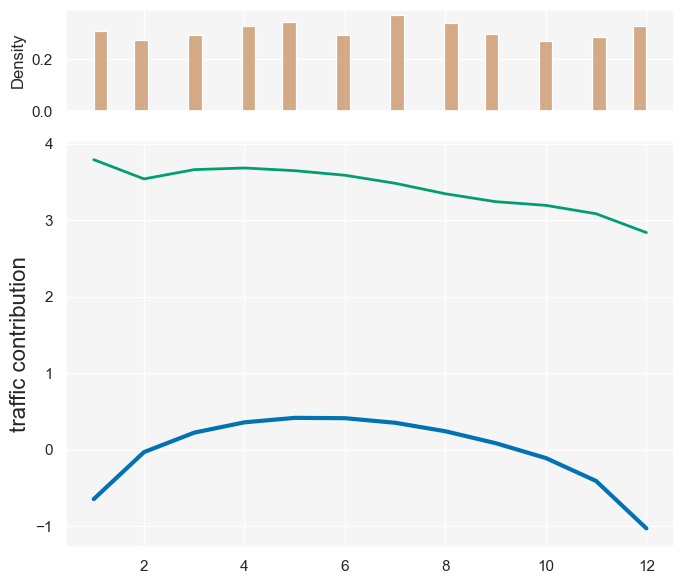

In [139]:
month_visualisation = visualisation_data[visualisation_data['feat_name'] == 'month'] 
month_values = np.linspace(x_metro['month'].min(), x_metro['month'].max(), len(month_visualisation['y'].iloc[0]))

fig, axes = plt.subplots(2, 
                         1, 
                         figsize=(7, 6),
                         sharex=True,  
                         gridspec_kw=dict(height_ratios = [1, 4])
                    )
axes[1].plot(month_values, nam_month_linefit(month_visualisation['x'].iloc[0]), color = colorblind_colors[2], linewidth = 2, label = 'NAM')
axes[1].plot(month_values, month_visualisation['y'].iloc[0] , color = colorblind_colors[0], linewidth = 3, label = 'NODE-GAM')
sns.histplot(x_metro['month'], ax = axes[0], stat='density', color = colorblind_colors[5])
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
#plt.xlabel('Month of the year', fontsize = 14)
plt.ylabel('traffic contribution', fontsize = 16)

plt.tight_layout()
plt.show()


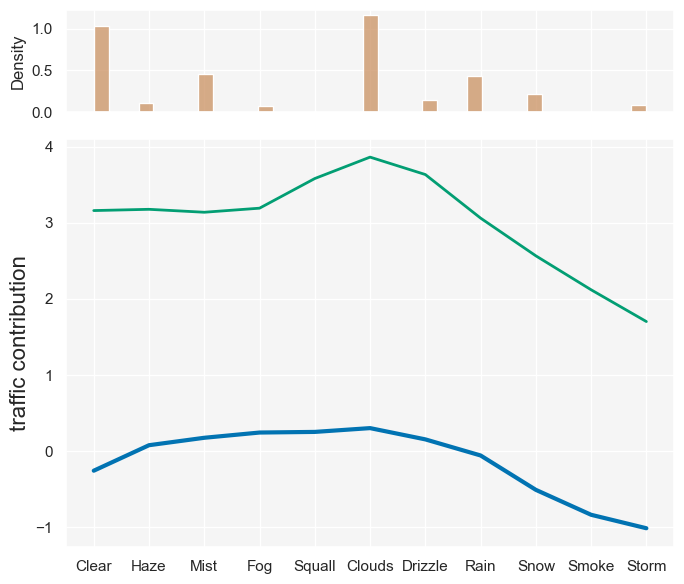

In [140]:
list_of_weather = list(weather_dict.keys())
index = list_of_weather.index('Thunderstorm')
list_of_weather[index] = 'Storm'
weather_visualisation = visualisation_data[visualisation_data['feat_name'] == 'weather_main'] 
weather_values = np.linspace(x_metro['weather_main'].min(), x_metro['weather_main'].max(), len(weather_visualisation['y'].iloc[0]))

fig, axes = plt.subplots(2, 
                         1, 
                         figsize=(7, 6),
                         sharex=True,  
                         gridspec_kw=dict(height_ratios = [1, 4])
                    )
axes[1].plot(list_of_weather, nam_weather_linefit(weather_visualisation['x'].iloc[0]), color = colorblind_colors[2], linewidth = 2, label = 'NAM')
axes[1].plot(list_of_weather, weather_visualisation['y'].iloc[0] , color = colorblind_colors[0], linewidth = 3, label = 'NODE-GAM')
sns.histplot(x_metro['weather_main'], ax = axes[0], stat='density', color = colorblind_colors[5])
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
#plt.xlabel('Weather', fontsize = 14)
plt.ylabel('traffic contribution', fontsize = 16)

plt.tight_layout()
plt.show()
